# Problem 2

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy.spatial import distance

Using TensorFlow backend.


## Load the dataset

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

n_image_train, n_pixel_train = x_train.shape
n_image_test, n_pixel_test = x_test.shape

### Flip images with probabilty 0.03

In [4]:
# np.random.seed(0)

# Rand matrix for train set
rand_matrix_1 = np.random.rand(n_image_train, n_pixel_train)
rand_matrix_2 = np.random.rand(n_image_train, n_pixel_train)

# Rand matrix for test set
rand_matrix_3 = np.random.rand(n_image_test, n_pixel_test)

In [5]:
# Generate the noisy train set
x_train_noisy_1 = np.where(rand_matrix_1 <= 0.03, 1.0 - x_train, x_train)
x_train_noisy_2 = np.where(rand_matrix_2 <= 0.03, 1.0 - x_train, x_train)

x_train_noisy = np.concatenate((x_train_noisy_1, x_train_noisy_2))
x_train = np.concatenate((x_train, x_train))

In [6]:
# Generate the boisy test set
x_test_noisy = np.where(rand_matrix_3 <= 0.03, 1.0 - x_test, x_test)

In [7]:
x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 28, 28, 1))
x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy),28, 28, 1))
x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test),28, 28, 1))

### Sample 10% train data

In [8]:
sample = np.random.choice(120000, 12000, replace = False)

### Define a function to plot the digit

In [9]:
def plot(decoded_imgs, origin, best_index, worst_index):
    n = len(best_index)

    plt.figure(figsize=(20, 4))

    print("The original best set of digits:")
    for i in range(n):
        # display best
        ax = plt.subplot(2, n, i+1)
        plt.imshow(origin[best_index[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    plt.figure(figsize=(20, 4))

    print("The predict best set of digits:")
    for i in range(n):
        # display best
        ax = plt.subplot(2, n, i+1)
        plt.imshow(decoded_imgs[best_index[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    print("The original worst set of digits:")
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(origin[worst_index[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    print("The predict worst set of digits:")
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[worst_index[i]].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show() 

## Implement a convolutional autoencoder

In [10]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

### 1. More filters and less layers

In [11]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_1 = Model(input_img, decoded)
autoencoder_1.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [12]:
autoencoder_1.fit(x_train_noisy[sample], x_train[sample],
                  epochs=20,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test),
                  callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 38s - loss: 0.2877 - mean_squared_error: 0.0725 - val_loss: 0.1513 - val_mean_squared_error: 0.0301

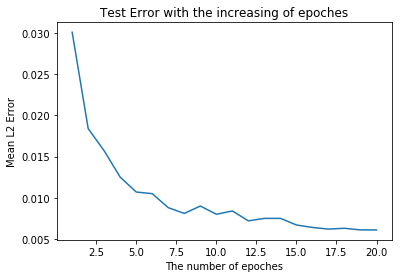

In [13]:
# Plot the MSE for autoencoder 1
mse_1 = [0.0301, 0.0184, 0.0157, 0.0125, 0.0107,
         0.0105, 0.0088, 0.0081, 0.0090, 0.0080,
         0.0084, 0.0072, 0.0075, 0.0075, 0.0067,
         0.0064, 0.0062, 0.0063, 0.0061, 0.0061]

epoches = [i + 1 for i in range(20)]

plt.plot(epoches, mse_1)
plt.title("Test Error with the increasing of epoches")
plt.xlabel("The number of epoches")
plt.ylabel("Mean L2 Error")
plt.show()

The original best set of digits:


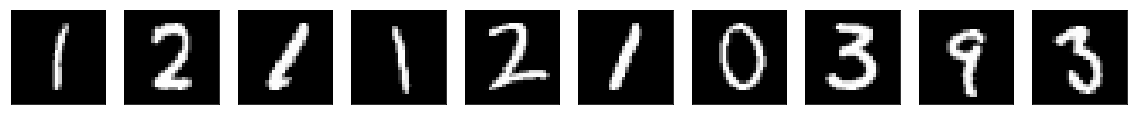

The predict best set of digits:


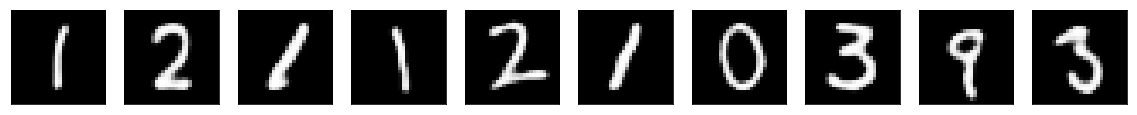

The original worst set of digits:


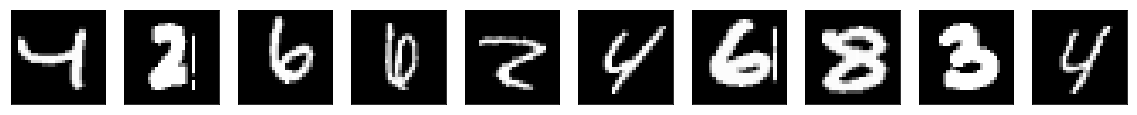

The predict worst set of digits:


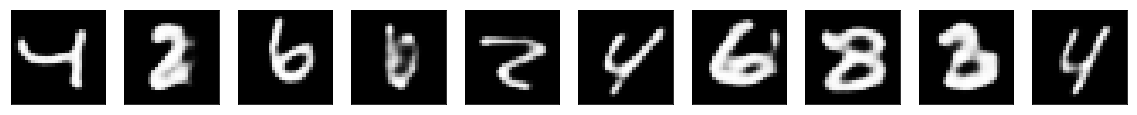

In [15]:
# Plot the worst - best set of digits
decoded_imgs_1 = autoencoder_1.predict(x_test_noisy)
error_1 = []

for i in range(decoded_imgs_1.shape[0]):    
    error_1.append(distance.euclidean(decoded_imgs_1[i].flatten(), x_test_noisy[i].flatten()))
    
n = 10

index = np.argsort(error_1)
best_index_1 = index[:n]
worst_index_1 = index[-n:]
plot(decoded_imgs_1, x_test, best_index_1, worst_index_1)

### 2. Less filters and more layers

In [16]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_2 = Model(input_img, decoded)
autoencoder_2.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [17]:
autoencoder_2.fit(x_train_noisy[sample], x_train[sample],
                  epochs=20,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test),
                  callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 23s - loss: 0.3662 - mean_squared_error: 0.0991 - val_loss: 0.2361 - val_mean_squared_error: 0.0597

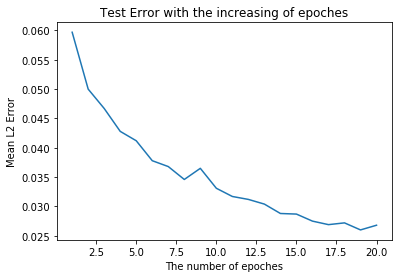

In [18]:
# Plot the MSE for autoencoder 2
mse_2 = [0.0597, 0.0500, 0.0467, 0.0428, 0.0412,
         0.0378, 0.0368, 0.0346, 0.0365, 0.0331,
         0.0317, 0.0312, 0.0304, 0.0288, 0.0287,
         0.0275, 0.0269, 0.0272, 0.0260, 0.0268]

epoches = [i + 1 for i in range(20)]

plt.plot(epoches, mse_2)
plt.title("Test Error with the increasing of epoches")
plt.xlabel("The number of epoches")
plt.ylabel("Mean L2 Error")
plt.show()

The original best set of digits:


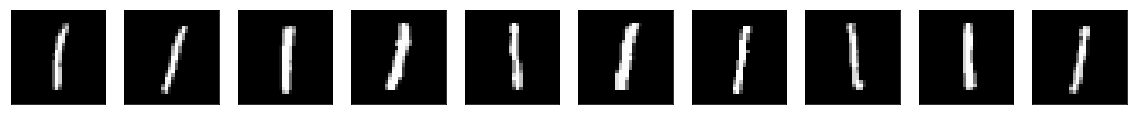

The predict best set of digits:


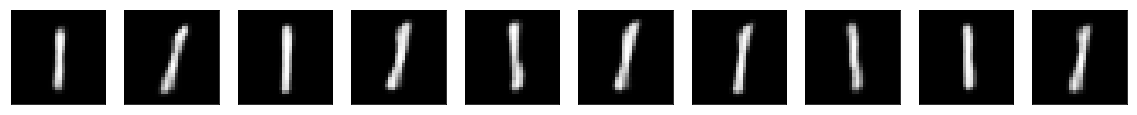

The original worst set of digits:


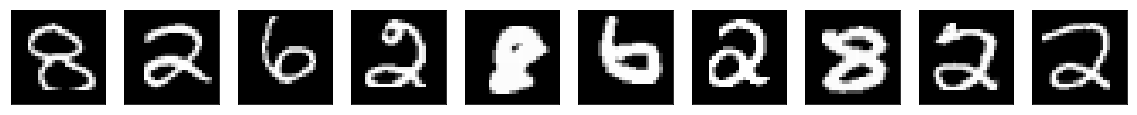

The predict worst set of digits:


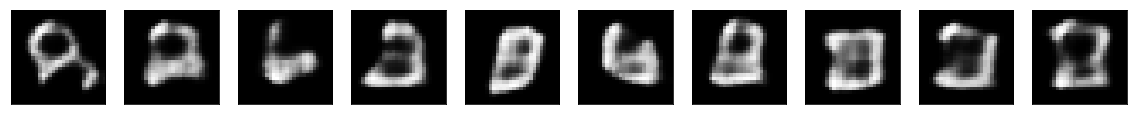

In [19]:
# Plot the worst - best set of digits
decoded_imgs_2 = autoencoder_2.predict(x_test_noisy)
error_2 = []

for i in range(decoded_imgs_2.shape[0]):    
    error_2.append(distance.euclidean(decoded_imgs_2[i].flatten(), x_test_noisy[i].flatten()))
    
n = 10

index = np.argsort(error_2)
best_index_2 = index[:n]
worst_index_2 = index[-n:]
plot(decoded_imgs_2, x_test, best_index_2, worst_index_2)

### 3. More filters and more layers

In [20]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_3 = Model(input_img, decoded)
autoencoder_3.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [21]:
autoencoder_3.fit(x_train_noisy[sample], x_train[sample],
                  epochs=20,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test),
                  callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 47s - loss: 0.3381 - mean_squared_error: 0.0898 - val_loss: 0.2290 - val_mean_squared_error: 0.0561

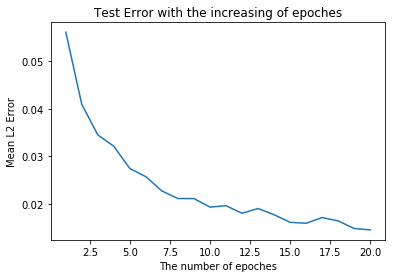

In [22]:
# Plot the MSE for autoencoder 3
mse_3 = [0.0561, 0.0409, 0.0345, 0.0321, 0.0274,
         0.0257, 0.0227, 0.0211, 0.0211, 0.0193,
         0.0196, 0.0180, 0.0190, 0.0177, 0.0161,
         0.0159, 0.0171, 0.0164, 0.0148, 0.0145]

epoches = [i + 1 for i in range(20)]

plt.plot(epoches, mse_3)
plt.title("Test Error with the increasing of epoches")
plt.xlabel("The number of epoches")
plt.ylabel("Mean L2 Error")
plt.show()

The original best set of digits:


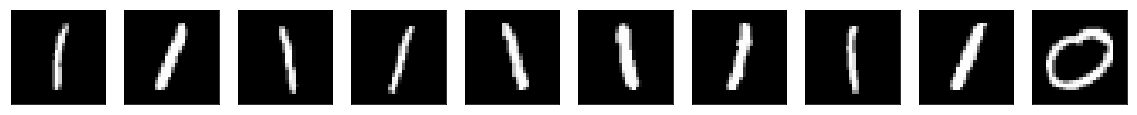

The predict best set of digits:


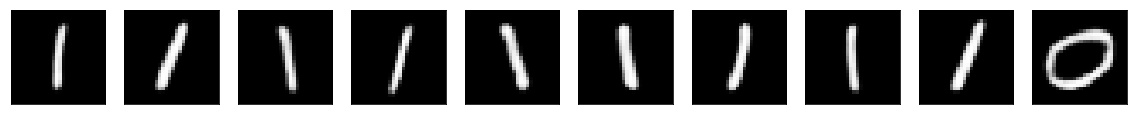

The original worst set of digits:


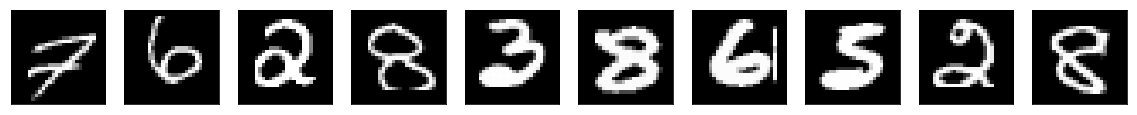

The predict worst set of digits:


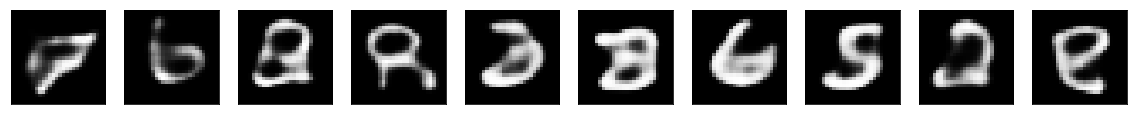

In [23]:
# Plot the worst - best set of digits
decoded_imgs_3 = autoencoder_3.predict(x_test_noisy)
error_3 = []

for i in range(decoded_imgs_3.shape[0]):    
    error_3.append(distance.euclidean(decoded_imgs_3[i].flatten(), x_test_noisy[i].flatten()))
    
n = 10

index = np.argsort(error_3)
best_index_3 = index[:n]
worst_index_3 = index[-n:]
plot(decoded_imgs_3, x_test, best_index_3, worst_index_3)

### 4. Change the size of filters

In [24]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder_4 = Model(input_img, decoded)
autoencoder_4.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [25]:
autoencoder_4.fit(x_train_noisy[sample], x_train[sample],
                  epochs=20,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test),
                  callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 40s - loss: 0.3231 - mean_squared_error: 0.0852 - val_loss: 0.1885 - val_mean_squared_error: 0.0426

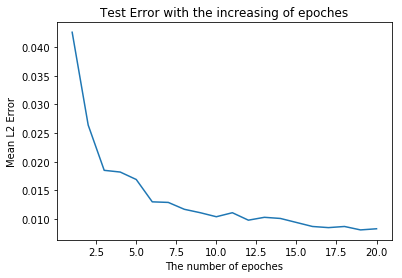

In [26]:
# Plot the MSE for autoencoder 4
mse_4 = [0.0426, 0.0264, 0.0185, 0.0182, 0.0169,
         0.0130, 0.0129, 0.0117, 0.0111, 0.0104,
         0.0111, 0.0098, 0.0103, 0.0101, 0.0094,
         0.0087, 0.0085, 0.0087, 0.0081, 0.0083]

epoches = [i + 1 for i in range(20)]

plt.plot(epoches, mse_4)
plt.title("Test Error with the increasing of epoches")
plt.xlabel("The number of epoches")
plt.ylabel("Mean L2 Error")
plt.show()

The original best set of digits:


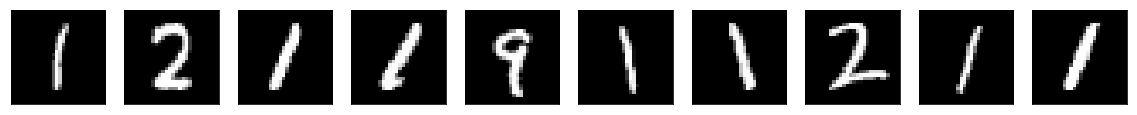

The predict best set of digits:


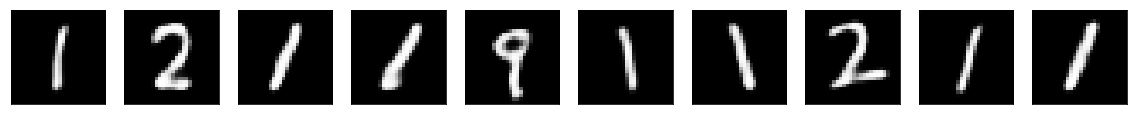

The original worst set of digits:


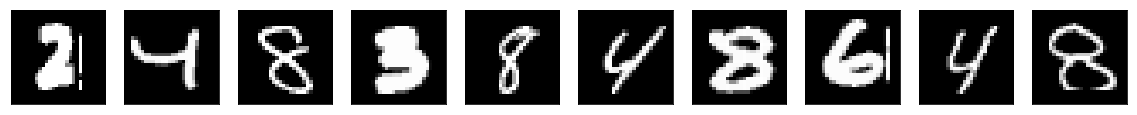

The predict worst set of digits:


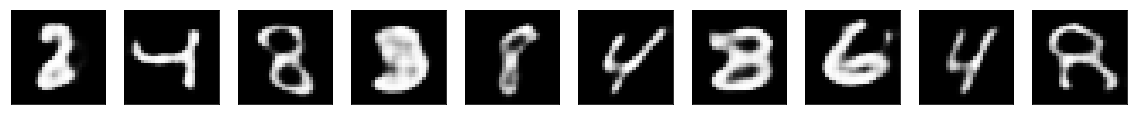

In [27]:
# Plot the worst - best set of digits
decoded_imgs_4 = autoencoder_4.predict(x_test_noisy)
error_4 = []

for i in range(decoded_imgs_4.shape[0]):    
    error_4.append(distance.euclidean(decoded_imgs_4[i].flatten(), x_test_noisy[i].flatten()))
    
n = 10

index = np.argsort(error_4)
best_index_4 = index[:n]
worst_index_4 = index[-n:]
plot(decoded_imgs_4, x_test, best_index_4, worst_index_4)